In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# CONFIG
RAW_DATA_PATH = "../data/raw/dataset_BATTLE_END_raw.csv"
CLEAN_DATA_PATH = "../data/dataset_battles_clean.csv"

print("[+] Configuration loaded.")

[+] Configuration loaded.


In [2]:
# LOAD DATA
if os.path.exists(RAW_DATA_PATH):
    df = pd.read_csv(RAW_DATA_PATH)
    print(f"[+] Loaded {len(df)} battle events.")
else:
    print(f"[-] File not found: {RAW_DATA_PATH}. Please run download_data.ipynb first.")
    df = pd.DataFrame()

if not df.empty:
    # JSON EXPANSION
    # Function to parse JSON safely
    def clean_json(x):
        if isinstance(x, dict): return x
        try:
            return json.loads(x)
        except:
            return {}


    df['context_data'] = df['context_data'].apply(clean_json)
    df_context = pd.json_normalize(df['context_data'])

    # Remove duplicated columns (world, biome, timestamp) from JSON
    cols_to_drop = df_context.columns.intersection(df.columns)
    if not cols_to_drop.empty:
        df_context = df_context.drop(columns=cols_to_drop)

    # Join
    df_final = df.join(df_context).drop(columns=['context_data'])

    print("[+] JSON expanded successfully.")
    display(df_final.head(3))

[+] Loaded 457 battle events.
[+] JSON expanded successfully.


,event_id,server_id,timestamp,player_uuid,category,action_type,world,biome,battleId,playerUuid,result,opponentType,durationMs,faintedCount,teamStatusJson
0,4561,xerneas,2026-01-19T19:24:03.964Z,da367a1f-0bdd-44ff-abe8-7d8818639710,COMBAT,BATTLE_END,minecraft:void_world,minecraft:plains,a53c2a1a-fd8d-438d-ad80-92041e4f3ac8,da367a1f-0bdd-44ff-abe8-7d8818639710,WIN,WILD,9365,0,"[Ceruledge:98.8%, Dragapult:100.0%, Greninja:1..."
1,4562,xerneas,2026-01-19T19:24:03.964Z,da367a1f-0bdd-44ff-abe8-7d8818639710,COMBAT,BATTLE_END,minecraft:void_world,minecraft:plains,8d7427f6-c156-4107-8079-964909edef86,da367a1f-0bdd-44ff-abe8-7d8818639710,WIN,WILD,9170,0,"[Ceruledge:98.5%, Dragapult:100.0%, Greninja:1..."
2,4563,xerneas,2026-01-19T19:24:03.964Z,da367a1f-0bdd-44ff-abe8-7d8818639710,COMBAT,BATTLE_END,minecraft:void_world,minecraft:plains,2bb602ba-154e-4e48-b472-0b2ef9800fe8,da367a1f-0bdd-44ff-abe8-7d8818639710,WIN,WILD,11352,0,"[Ceruledge:98.5%, Dragapult:100.0%, Greninja:1..."


In [3]:
# ADVANCED FEATURE ENGINEERING

if not df_final.empty:
    # A. Convert Duration to Seconds
    if 'durationMs' in df_final.columns:
        df_final['duration_sec'] = df_final['durationMs'] / 1000


    # B. Parse Team Status
    # Format example: "[Ceruledge:98.8%, Dragapult:100.0%]"
    # We want to know: Team Size and Average Health
    def parse_team_stats(team_str):
        if not isinstance(team_str, str) or not team_str:
            return 0, 0.0

        # Regex to find percentages (e.g., 98.8)
        # Looks for digits followed by optional decimal, before a %
        matches = re.findall(r'(\d+(?:\.\d+)?)%', team_str)

        if not matches:
            return 0, 0.0

        hp_values = [float(x) for x in matches]
        team_size = len(hp_values)
        avg_hp = sum(hp_values) / team_size

        return team_size, avg_hp


    # Apply the function and create two new columns
    if 'teamStatusJson' in df_final.columns:
        print("[INFO] Parsing team data (Regex)...")
        # Apply returns a tuple, we split it into columns
        df_final[['team_size', 'team_avg_hp']] = df_final['teamStatusJson'].apply(
            lambda x: pd.Series(parse_team_stats(x))
        )

    # C. Server ID (One-Hot)
    if 'server_id' in df_final.columns:
        server_dummies = pd.get_dummies(df_final['server_id'], prefix='server')
        df_final = pd.concat([df_final, server_dummies], axis=1)

    # D. Target Creation
    # WIN = 1, LOSS/FLEE = 0
    # We treat FLEE as a "Non-Win" for the AI
    if 'result' in df_final.columns:
        df_final['target'] = df_final['result'].apply(lambda x: 1 if x == 'WIN' else 0)

    print("[+] Feature Engineering complete.")
    display(df_final[['result', 'target', 'duration_sec', 'team_size', 'team_avg_hp']].head())

[INFO] Parsing team data (Regex)...
[+] Feature Engineering complete.


,result,target,duration_sec,team_size,team_avg_hp
0,WIN,1,9.365,5.0,99.10
1,WIN,1,9.170,5.0,99.06
2,WIN,1,11.352,5.0,99.08
3,WIN,1,9.764,5.0,99.08
4,WIN,1,9.371,5.0,98.90


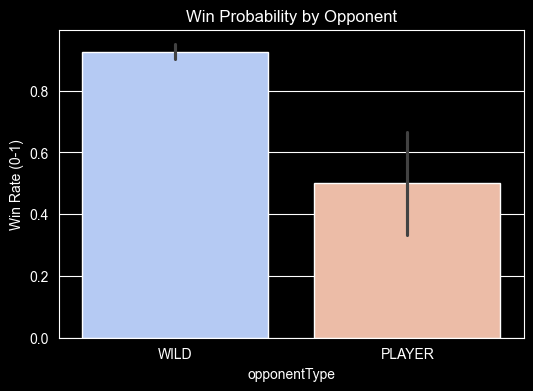

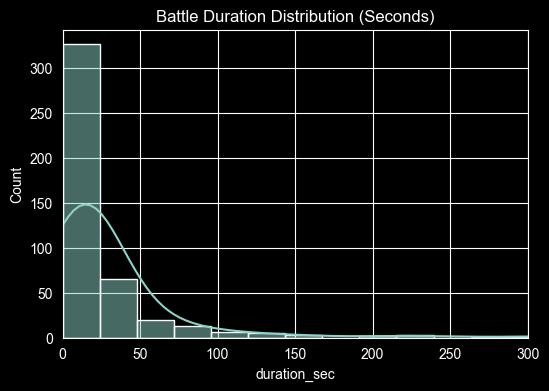

In [6]:
# 4. DATA ANALYSIS & VISUALIZATION

if not df_final.empty and 'target' in df_final.columns:
    # Graph 1: Winrate by Opponent Type (Wild vs Trainer)
    if 'opponentType' in df_final.columns:
        plt.figure(figsize=(6, 4))
        sns.barplot(x='opponentType', y='target', hue='opponentType', data=df_final, palette='coolwarm', legend=False)
        plt.title('Win Probability by Opponent')
        plt.ylabel('Win Rate (0-1)')
        plt.show()

    # Graph 2: Duration distribution
    plt.figure(figsize=(6, 4))
    sns.histplot(df_final['duration_sec'], bins=30, kde=True)
    plt.title('Battle Duration Distribution (Seconds)')
    plt.xlim(0, 300)  # Limit to 5 mins to see details
    plt.show()

In [5]:
# 5. CLEANUP & SAVE

if not df_final.empty:
    # Select useful columns
    cols_to_keep = [
        'target',
        'result',
        'opponentType',
        'duration_sec',
        'team_size',
        'team_avg_hp',
        'faintedCount',
        'world',
        'biome'
    ]
    # Add server columns dynamically
    cols_to_keep.extend([col for col in df_final.columns if 'server_' in col])

    # Filter
    df_export = df_final[cols_to_keep].copy()

    # Save
    df_export.to_csv(CLEAN_DATA_PATH, index=False)
    print(f"[+] Clean dataset saved to: {CLEAN_DATA_PATH}")
    display(df_export.head())

[+] Clean dataset saved to: ../data/dataset_battles_clean.csv


,target,result,opponentType,duration_sec,team_size,team_avg_hp,faintedCount,world,biome,server_id,server_xerneas,server_yveltal
0,1,WIN,WILD,9.365,5.0,99.10,0,minecraft:void_world,minecraft:plains,xerneas,True,False
1,1,WIN,WILD,9.170,5.0,99.06,0,minecraft:void_world,minecraft:plains,xerneas,True,False
2,1,WIN,WILD,11.352,5.0,99.08,0,minecraft:void_world,minecraft:plains,xerneas,True,False
3,1,WIN,WILD,9.764,5.0,99.08,0,minecraft:void_world,minecraft:plains,xerneas,True,False
4,1,WIN,WILD,9.371,5.0,98.90,0,minecraft:void_world,minecraft:plains,xerneas,True,False
